In [9]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import os
import cv2
from tqdm import tqdm
from utils import get_2D_projections
from datetime import datetime
import traceback
from PIL import Image

%env SITK_SHOW_COMMAND 'C:\ProgramData\slicer.org\Slicer 5.4.0\Slicer'

env: SITK_SHOW_COMMAND='C:\ProgramData\slicer.org\Slicer 5.4.0\Slicer'


In [2]:
import sys

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Utils import utils

In [3]:
config = utils.read_config()
config

{'common': {'paths': {'source_path_wd': 'E:/U-CAN-Lymfom_A',
   'source_path_bd': '/media/andres/T7 Shield/ucan_lymfom'}},
 'selection': {'filenames': {'rejected_folder_filename': 'Rejected_exams_from_U-CAN-Lymfom.xlsx',
   'sourcefiltered_folder_filename': 'SourceFiltered_exams_from_U-CAN-Lymfom.xlsx',
   'incomplete_folders_filename_initial': 'No_PTorCT_exams_from_U-CAN-Lymfom1.xlsx',
   'incomplete_folders_filename_final': 'No_PTorCT_exams_from_U-CAN-Lymfom2.xlsx',
   'selected_folders_beforefiltering_filename': 'Selected_exams_beforefiltering_from_U-CAN-Lymfom.xlsx',
   'selected_folders_afterfiltering_filename': 'Selected_exams_afterfiltering_from_U-CAN-Lymfom.xlsx',
   'final_selected_images_filename': 'Excel_files/06_11_2023/Final_Selected_exams_from_U-CAN-Lymfom.xlsx',
   'list_of_distorted_images_filename': 'Distorted_exams_from_U-CAN-Lymfom.xlsx'}},
 'metadata': {'filenames': {'final_selected_images_filename': 'Finalized_dataset.xlsx'}},
 'resampling': {'voxel_spacing': [2.03

In [4]:
source_path_wd = config['common']['paths']['source_path_wd']
source_path_bd = config['common']['paths']['source_path_bd']
final_selected_images_filename = config['metadata']['filenames']['final_selected_images_filename']
#projection_path = 'E:\\Sambit\\Project_10\\Data\\2D Projections\\' #config['projections']['paths']['destination_path']
projection_path = 'G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/'

selection_dataframe = os.path.join(source_path_wd, final_selected_images_filename)
final_projections = os.path.join(source_path_wd, projection_path)
final_projections

'G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/'

In [5]:
selection_dataframe

'E:/U-CAN-Lymfom_A\\Finalized_dataset.xlsx'

In [6]:
projections = config['projections']
projections

{'paths': {'destination_path': 'Selected_for_UCAN_project/2dprojections'},
 'variables': {'modality': ['CT', 'PT', 'SUV'],
  'tissue_type': ['LT', 'AT', 'LT', 'B', 'N'],
  'projection_type': ['sum', 'min', 'max', 'mean', 'std'],
  'angles': [0, 90]}}

In [7]:
modality = projections['variables']['modality']
ttype = projections['variables']['tissue_type'][:-1]
ptype = projections['variables']['projection_type']
angles = projections['variables']['angles']

In [8]:
ttype

['LT', 'AT', 'LT', 'B']

In [9]:
config_size = config['resampling']['image_size']
config_spacing = config['resampling']['voxel_spacing']
print('config_size: ', config_size)
print('config_spacing: ', config_spacing)

config_size:  [256, 256, 256]
config_spacing:  [2.0364201068878174, 2.0364201068878174, 3.0]


In [10]:
#resampled_destination_path = 'E:/Sambit/Other_Projects/UCAN/Resampled_SUV_CT/'
#resampled_destination_path = 'E:/Sambit/Project_10/Data/Resampled_SUV_CT/'
resampled_destination_path = 'G:/UCAN_project/'
#resampled_destination_path = 'F:/ucan_lymfom/Resampled_SUV_CT/Sample31Oct2023/'

In [11]:
resampled_directory_list = []

for dirs, subdirs, files in os.walk(resampled_destination_path):
    for file in files:
        file_path = str(os.path.join(dirs, file))
        file_path = file_path.replace('\\','/')
        resampled_directory_list.append(file_path)
        print(file_path)

G:/UCAN_project/npr100169878450_SUV_CT/20130611/CT.nii.gz
G:/UCAN_project/npr100169878450_SUV_CT/20130611/SUV.nii.gz
G:/UCAN_project/npr100169878450_SUV_CT/20130412/CT.nii.gz
G:/UCAN_project/npr100169878450_SUV_CT/20130412/SUV.nii.gz
G:/UCAN_project/npr100222372477_SUV_CT/20171207/CT.nii.gz
G:/UCAN_project/npr100222372477_SUV_CT/20171207/SUV.nii.gz
G:/UCAN_project/npr100222372477_SUV_CT/20160314/CT.nii.gz
G:/UCAN_project/npr100222372477_SUV_CT/20160314/SUV.nii.gz
G:/UCAN_project/npr100589333593_SUV_CT/20190205/CT.nii.gz
G:/UCAN_project/npr100589333593_SUV_CT/20190205/SUV.nii.gz
G:/UCAN_project/npr100825923056_SUV_CT/20220510/CT.nii.gz
G:/UCAN_project/npr100825923056_SUV_CT/20220510/SUV.nii.gz
G:/UCAN_project/npr102928239238_SUV_CT/20190108/CT.nii.gz
G:/UCAN_project/npr102928239238_SUV_CT/20190108/SUV.nii.gz
G:/UCAN_project/npr102928239238_SUV_CT/20110601/CT.nii.gz
G:/UCAN_project/npr102928239238_SUV_CT/20110601/SUV.nii.gz
G:/UCAN_project/npr102928239238_SUV_CT/20101115/CT.nii.gz
G:/UCA

In [12]:
resampled_directory_df = pd.DataFrame(resampled_directory_list, columns=['directory'])
resampled_directory_df[['source_directory', 'patient_directory', 'scan_date', 'SUV_CT']] = resampled_directory_df['directory'].str.rsplit(pat='/', n=3, expand=True)
resampled_directory_df[['npr', 'extra']] = resampled_directory_df['patient_directory'].str.split(pat='_', n=1, expand=True)
resampled_directory_df.drop(columns=['directory','extra', 'SUV_CT'], inplace=True)
resampled_directory_df.drop_duplicates(inplace=True)

resampled_directory_df.head()

,source_directory,patient_directory,scan_date,npr
0,G:/UCAN_project,npr100169878450_SUV_CT,20130611,npr100169878450
2,G:/UCAN_project,npr100169878450_SUV_CT,20130412,npr100169878450
4,G:/UCAN_project,npr100222372477_SUV_CT,20171207,npr100222372477
6,G:/UCAN_project,npr100222372477_SUV_CT,20160314,npr100222372477
8,G:/UCAN_project,npr100589333593_SUV_CT,20190205,npr100589333593


In [13]:
resampled_directory_df.shape

(11, 4)

In [14]:
resampled_directory_df.columns

Index(['source_directory', 'patient_directory', 'scan_date', 'npr'], dtype='object')

In [15]:
for index, row in resampled_directory_df.iterrows():

    CT_ptype = 'mean'
    SUV_ptype = 'max'
    angle = 90
    
    for mod in ['CT','SUV']:
        for item in ['MIP', 'bone', 'lean', 'adipose', 'air']:
            dir_path = projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/' + mod + '_' + item
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

    
    CTnii_path = resampled_destination_path + str(row['npr']) + '_SUV_CT/' + str(row['scan_date']) + '/' + 'CT.nii.gz'
    SUVnii_path = resampled_destination_path + str(row['npr']) + '_SUV_CT/' + str(row['scan_date']) + '/' + 'SUV.nii.gz'

    CT_img =sitk.ReadImage(CTnii_path)
    SUV_img =sitk.ReadImage(SUVnii_path)

    bone_mask, lean_mask, adipose_mask, air_mask = utils.get_proj_after_mask(CT_img)

    multiply= sitk.MultiplyImageFilter()

    CT_bone = multiply.Execute(CT_img,sitk.Cast(bone_mask,CT_img.GetPixelID()))
    CT_lean = multiply.Execute(CT_img,sitk.Cast(lean_mask,CT_img.GetPixelID()))
    CT_adipose = multiply.Execute(CT_img,sitk.Cast(adipose_mask,CT_img.GetPixelID()))
    CT_air = multiply.Execute(CT_img,sitk.Cast(air_mask,CT_img.GetPixelID()))

    utils.get_2D_projections(CT_img, 'CT', CT_ptype, angle, invert_intensity= False, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_MIP/')
    utils.get_2D_projections(CT_bone, 'CT', CT_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_bone/')
    utils.get_2D_projections(CT_lean, 'CT', CT_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_lean/')
    utils.get_2D_projections(CT_adipose, 'CT', CT_ptype, angle, invert_intensity= False, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_adipose/')
    utils.get_2D_projections(CT_air, 'CT', CT_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_air/')
    
    SUV_bone = multiply.Execute(SUV_img,sitk.Cast(bone_mask,SUV_img.GetPixelID()))
    SUV_lean = multiply.Execute(SUV_img,sitk.Cast(lean_mask,SUV_img.GetPixelID()))
    SUV_adipose = multiply.Execute(SUV_img,sitk.Cast(adipose_mask,SUV_img.GetPixelID()))
    SUV_air = multiply.Execute(SUV_img,sitk.Cast(air_mask,SUV_img.GetPixelID()))

    utils.get_2D_projections(SUV_img, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_MIP/')
    utils.get_2D_projections(SUV_bone, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_bone/')
    utils.get_2D_projections(SUV_lean, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_lean/')
    utils.get_2D_projections(SUV_adipose, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_adipose/')
    utils.get_2D_projections(SUV_air, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_air/')

    





Finished generating 3 - mean intensity 2D projections from the CT volume image! 
Finished generating 3 - mean intensity 2D projections from the CT volume image! 
Finished generating 3 - mean intensity 2D projections from the CT volume image! 
Finished generating 3 - mean intensity 2D projections from the CT volume image! 
Finished generating 3 - mean intensity 2D projections from the CT volume image! 
Finished generating 3 - max intensity 2D projections from the SUV volume image! 
Finished generating 3 - max intensity 2D projections from the SUV volume image! 
Finished generating 3 - max intensity 2D projections from the SUV volume image! 
Finished generating 3 - max intensity 2D projections from the SUV volume image! 
Finished generating 3 - max intensity 2D projections from the SUV volume image! 
Finished generating 3 - mean intensity 2D projections from the CT volume image! 
Finished generating 3 - mean intensity 2D projections from the CT volume image! 
Finished generating 3 - mean

### Testing projections

folder structure: patient / scandate / CT_tissuetype/angle.npy

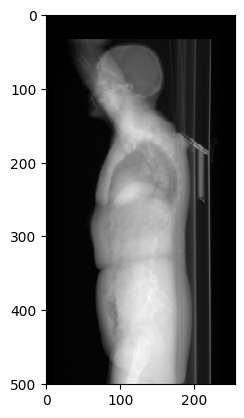

In [7]:
file_path = r'g:\U-CAN-Lymfom_A\Projections\2DProjections_ResampledImages_8Nov2023\npr104155030926\20200612\CT_MIP\0.0.npy'
temp = np.load(file_path)
plt.imshow(temp, cmap="gray")

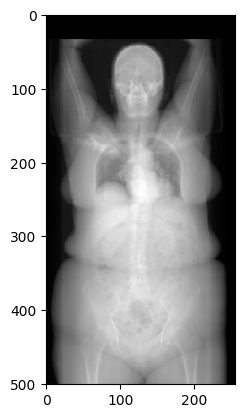

In [8]:
file_path = r'g:\U-CAN-Lymfom_A\Projections\2DProjections_ResampledImages_8Nov2023\npr104155030926\20200612\CT_MIP\-90.0.npy'
temp = np.load(file_path)
plt.imshow(temp, cmap="gray")